#**Core plotting functions**

Tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html

This tutorial explores the visualization possibilities of scanpy and is divided into three sections:

- Scatter plots for embeddings (eg. UMAP, t-SNE)
- Identification of clusters using known marker genes
- Visualization of differentially expressed genes

In this tutorial, we will use a dataset from 10X containing 68k cells from PBMC. Scanpy, includes in its distribution a reduced sample of this dataset consisting of only 700 cells and 765 highly variable genes. This dataset has been already preprocessed and UMAP computed.

In this tutorial, we will also use the following literature markers:

- B-cell: CD79A, MS4A1
- Plasma: IGJ (JCHAIN)
- T-cell: CD3D
- NK: GNLY, NKG7
- Myeloid: CST3, LYZ
- Monocytes: FCGR3A
- Dendritic: FCER1A

#**01 Scatter plots for embeddings**

With scanpy, scatter plots for tSNE, UMAP and several other embeddings are readily available using the sc.pl.tsne, sc.pl.umap etc. functions. 

Those functions access the data stored in adata.obsm. For example sc.pl.umap uses the information stored in adata.obsm['X_umap']. For more flexibility, any key stored in adata.obsm can be used with the generic function sc.pl.embedding.

In [ ]:
# install scanpy
!pip install scanpy

In [2]:
# import libraries
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

In [3]:
# configure settings
sc.set_figure_params(dpi=100, color_map = "viridis_r")
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2


**Load PBMC dataset**

(peripheral blood mononuclear cells)

In [4]:
# import dataset
pbmc = sc.datasets.pbmc68k_reduced()
print(pbmc) # 700 cells and 765 genes

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


**Visualization of gene expression and other variables**

For the scatter plots, the value to plot is given as the **color** argument. This can be any gene or any column in .obs, where .obs is a DataFrame containing the annotations per observation/cell.

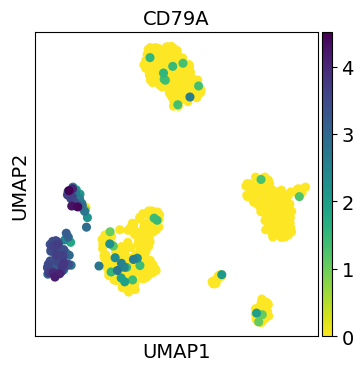

In [5]:
# rc_context is used for the figure size, in this case 4x4
with rc_context({"figure.figsize": (4,4)}):
  sc.pl.umap(pbmc, color="CD79A")

Multiple values can be given to color. In the following example we will plot 6 genes: ‘CD79A’, ‘MS4A1’, ‘IGJ’, CD3D’, ‘FCER1A’, and ‘FCGR3A’ to get an idea on where those marker genes are being expressed.

Also, we will plot two other values: n_counts which is the number of UMI (*Unic Molecular Identifier* - one UMI/RNA molecule) counts per cell (stored in .obs), and bulk_labels which is a categorical value containing the original labelling of the cells from 10X.

The number of plots per row is controlled using the ncols parameter. The maximum value plotted can be adjusted using vmax (similarly vmin can be used for the minimum value). In this case we use p99, which means to use as max value the 99 percentile. The max value can be a number or a list of numbers if the vmax wants to be set for multiple plots individually.

Also, we are using frameon=False to remove the boxes around the plots and s=50 to set the dot size.

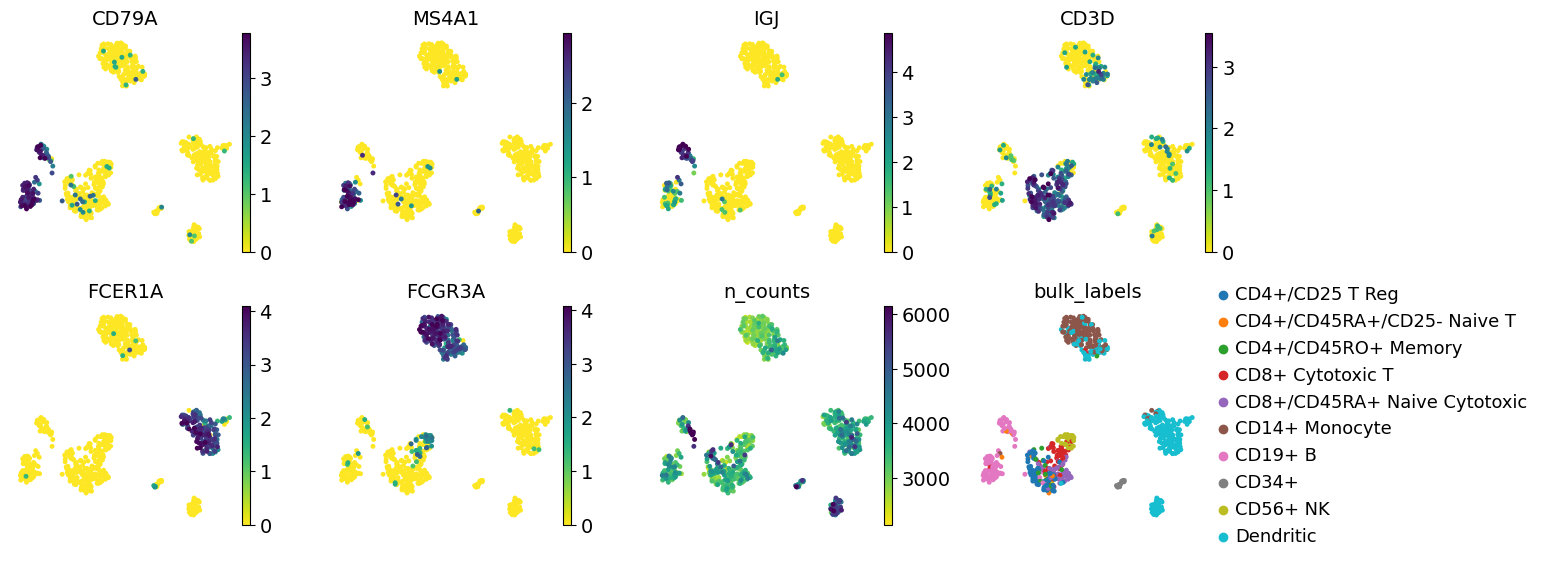

In [6]:
with rc_context({"figure.figsize": (3,3)}):
  sc.pl.umap(pbmc, color=["CD79A", "MS4A1", "IGJ", "CD3D", "FCER1A", "FCGR3A",
                          "n_counts", "bulk_labels"],
             s=50, frameon=False, ncols=4, vmax="p99")

In this plot we can see the groups of cells that express the marker genes and the agreement with the original cell labels.

The functions for scatterplots have many options that allow fine tuning of the images. For example, we can look at the clustering as follows:

In [7]:
# install Leiden
!pip install leidenalg

     |████████████████████████████████| 1.4MB 4.1MB/s 
     |████████████████████████████████| 3.2MB 10.5MB/s 


In [8]:
# compute clusters using the Leiden method and store the result with the name "clusters"
sc.tl.leiden(pbmc, key_added="clusters", resolution=0.5)

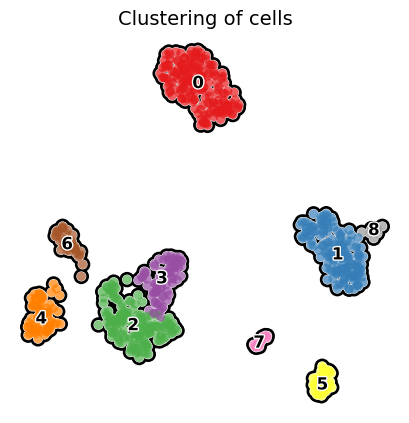

In [9]:
with rc_context({"figure.figsize": (5,5)}):
  sc.pl.umap(pbmc, color="clusters", add_outline=True, legend_loc="on data",
             legend_fontsize=12, legend_fontoutline=2, frameon=False,
             title="Clustering of cells", palette="Set1")

#**02 Identification of clusters based on known marker genes**

Frequently, clusters need to be labelled using well known marker genes. Using scatter plots we can see the expression of a gene and perhaps associate it with a cluster. Here, we will show other visual ways to associate marker genes to clusters using dotplots, violin plots, heatmaps and something that we call ‘tracksplot’. All of these visualizations summarize the same information, expression split by cluster, and the selection of the best results is left to the investigator do decide.

First, we set up a dictionary with the marker genes, as this will allow scanpy to automatically label the groups of genes:

In [10]:
marker_genes_dict = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Monocytes': ['FCGR3A'],
    'NK': ['GNLY', 'NKG7'],
    'Other': ['IGLL1'],
    'Plasma': ['IGJ'],
    'T-cell': ['CD3D']}

**dotplot**

A quick way to check the expression of these genes per cluster is to using a dotplot. This type of plot summarizes two types of information: the color represents the mean expression within each of the categories (in this case in each cluster) and the dot size indicates the fraction of cells in the categories expressing a gene.

Also, it is also useful to add a dendrogram to the graph to bring together similar clusters. The hierarchical clustering is computed automatically using the correlation of the PCA components between the clusters.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


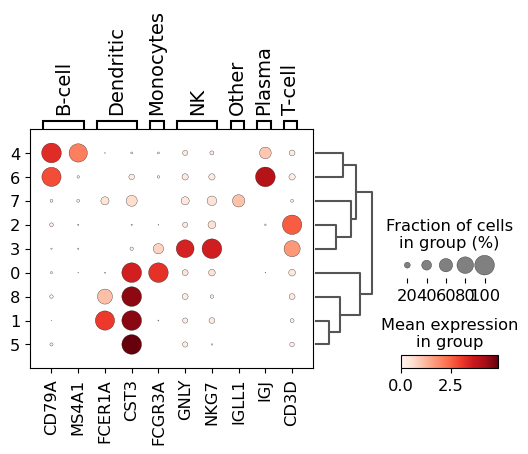

In [11]:
sc.pl.dotplot(pbmc, var_names=marker_genes_dict, groupby="clusters", dendrogram=True)

Using this plot, we can see that cluster 4 correspond to B-cells, cluster 2 is T-cells etc. This information can be used to manually annotate the cells as follows:

In [12]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Monocytes',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'B-cell',
     '5': 'Dendritic',
     '6': 'Plasma',
     '7': 'Other',
     '8': 'Dendritic'}

# add a new ".obs" column called "cell type" by mapping clusters to annotation using pandas "map" function
pbmc.obs["cell type"] = pbmc.obs["clusters"].map(cluster2annotation).astype("category")

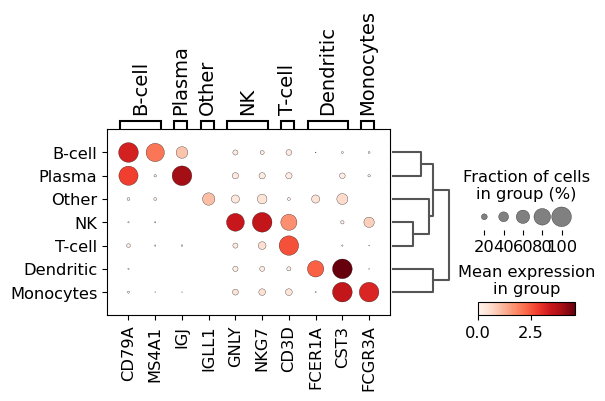

In [13]:
sc.pl.dotplot(pbmc, var_names=marker_genes_dict, groupby="cell type", dendrogram=True)

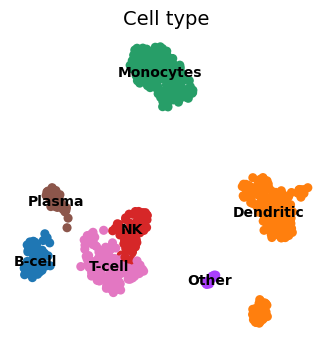

In [14]:
sc.pl.umap(pbmc, color="cell type", legend_loc="on data",
             legend_fontsize=10, frameon=False,
             title="Cell type")

**violin plot**

A different way to explore the markers is with violin plots. Here we can see the expression of CD79A in clusters 4 and 6, and MS4A1 in cluster 4.Compared to a dotplot, the violin plot gives us and idea of the distribution of gene expression values across cells.



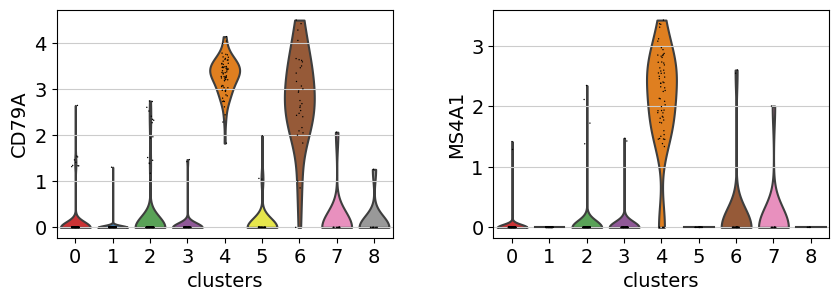

In [15]:
with rc_context({"figure.figsize": (4.5, 3)}):
  sc.pl.violin(pbmc, ["CD79A", "MS4A1"], groupby="clusters")

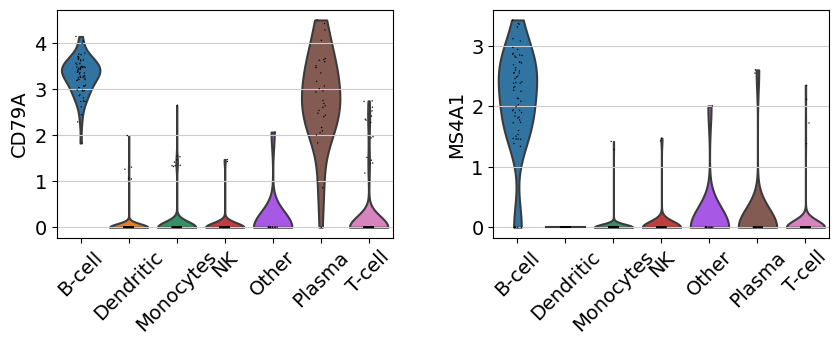

In [16]:
# same as above, but now based on cell type
with rc_context({"figure.figsize": (4.5, 3)}):
  sc.pl.violin(pbmc, ["CD79A", "MS4A1"], groupby="cell type", rotation=45)

**Note:** Violin plots can also be used to plot any numerical value stored in .obs. For example, here violin plots are used to compare the number of genes and the percentage of mitochondrial genes between the different clusters.

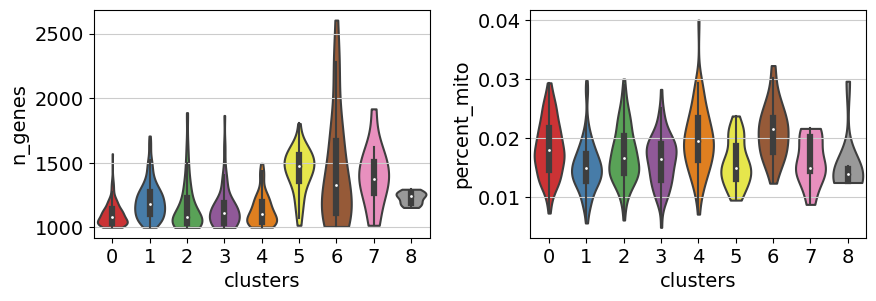

In [17]:
# use stripplot=False to remove internal dots
# inner="box" adds a boxplot inside violins
with rc_context({"figure.figsize": (4.5, 3)}):
  sc.pl.violin(pbmc, ["n_genes", "percent_mito"], groupby="clusters", stripplot=False,
               inner="box") 

**stacked-violin plots**

To simultaneously look at the violin plots for all marker genes we use sc.pl.stacked_violin. As previously, a dendrogram was added to group similar clusters

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


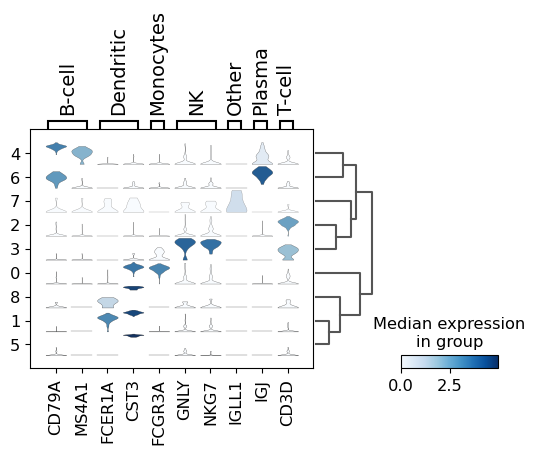

In [18]:
ax = sc.pl.stacked_violin(pbmc, var_names=marker_genes_dict, groupby="clusters",
                          swap_axes=False, dendrogram=True)

**matrix plot**

A simple way to visualize the expression of genes is with a matrix plot. This is a heatmap of the mean expression values per gene grouped by categories. This type plot basically shows the same information as the color in the dotplots.

Here, scale the expression of the genes from 0 to 1, being 1 the maximum mean expression and 0 the minimum.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


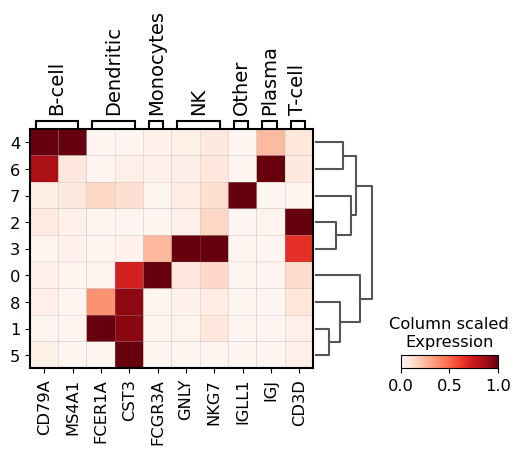

In [19]:
sc.pl.matrixplot(pbmc, var_names=marker_genes_dict, groupby="clusters",
                 dendrogram=True, cmap="Reds", standard_scale="var", colorbar_title="Column scaled\nExpression")

Other useful option is to normalize the gene expression using sc.pp.scale. Here we store this information under the scale layer. Afterwards we adjust the plot min and max and use a diverging color map (in this case RdBu_r where _r means reversed).



In [20]:
# scale and store results in layer
pbmc.layers["scaled"] = sc.pp.scale(pbmc, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


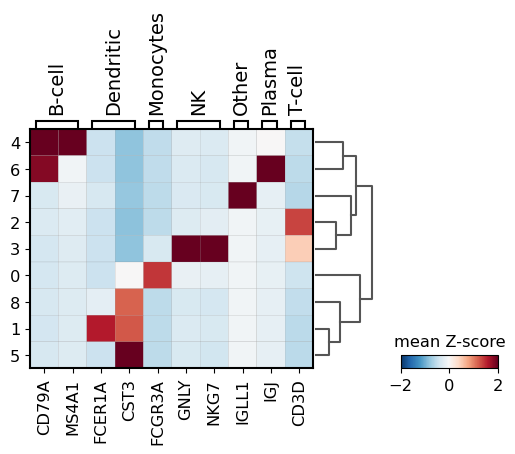

In [21]:
sc.pl.matrixplot(pbmc, marker_genes_dict, "clusters", dendrogram=True,
                 colorbar_title="mean Z-score", layer="scaled", vmin=-2, vmax=2, cmap="RdBu_r")

##**Combining plots in subplot**

An axis can be passed to a plot to combine multiple outputs as in the following example

In [22]:
# import library
import matplotlib.pyplot as plt

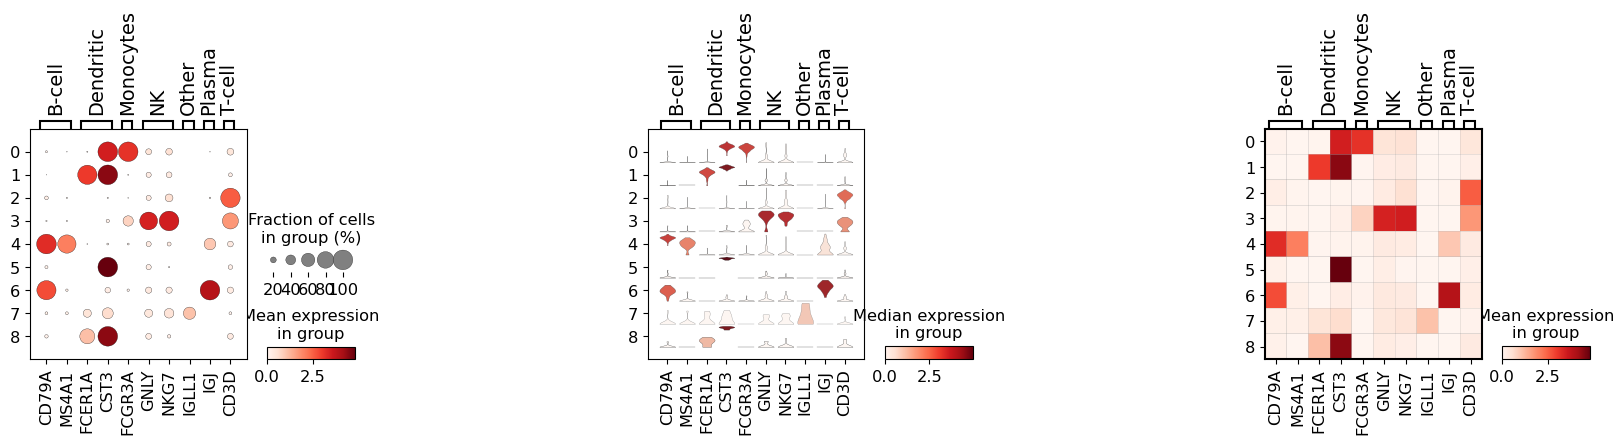

In [23]:
# 1 row, 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4), gridspec_kw={'wspace':0.9})

ax1_dict = sc.pl.dotplot(pbmc, marker_genes_dict, groupby="clusters", ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby="clusters", ax=ax2, show=False, cmap="Reds")
ax3_dict = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby="clusters", ax=ax3, show=False, cmap="Reds")

##**Heatmaps**

Heatmaps do not collapse cells as in previous plots. Instead, **each cells is shown in a row** (or column if swap_axes=True). The groupby information can be added and is shown using the same color code found for sc.pl.umap or any other embedding.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


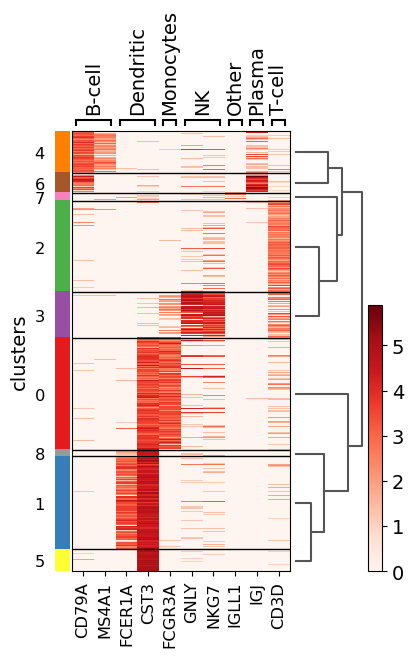

In [24]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby="clusters", cmap="Reds", dendrogram=True)

The heatmap can also be plotted on scaled data. In the next image, similar to the previus matrix plot the min and max had been adjusted and a divergent color map is used.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


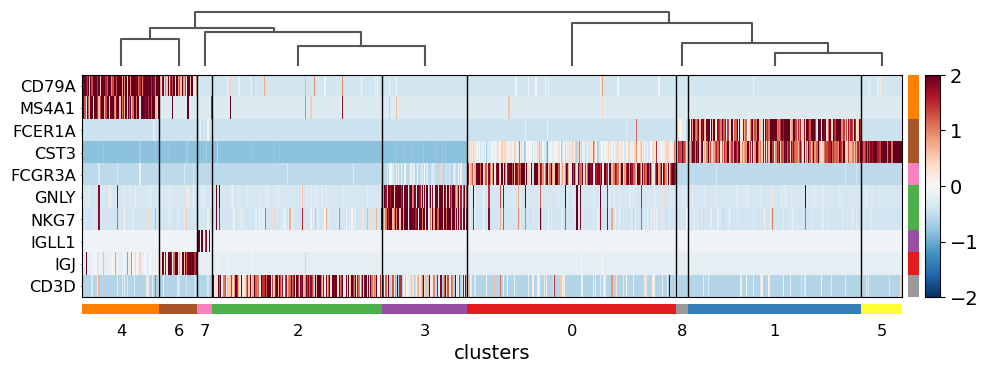

In [25]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby="clusters", layer="scaled", vmin=-2, vmax=2, 
                   cmap="RdBu_r", dendrogram=True, swap_axes=True, figsize=(11,4))

##**Tracksplot**

The track plot shows the same information as the heatmap, but, instead of a color scale, the gene expression is represented by **height**.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


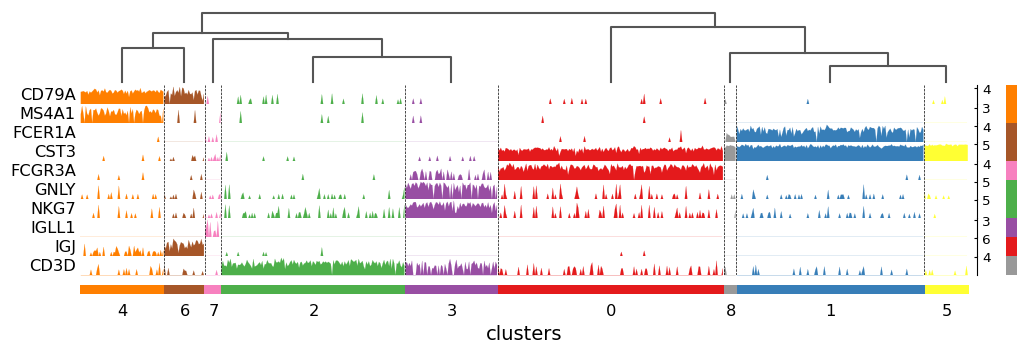

In [26]:
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby="clusters", dendrogram=True)

#**03 Visualization of marker genes**

Instead of characterizing clusters by known gene markers as previously, we can identify genes that are differentially expressed in the clusters or groups.

To identify differentially expressed genes we run sc.tl.rank_genes_groups. This function will take each group of cells and compare the distribution of each gene in a group against the distribution in all other cells not in the group. Here, we will use the original cell labels given by 10X to identify marker genes for those cell types.

In [27]:
sc.tl.rank_genes_groups(pbmc, groupby="clusters", method="wilcoxon")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##**Visualize marker genes using dotplot**

The dotplot visualization is useful to get an overview of the genes that show differential expression. To make the resulting image more compact we will use n_genes=4 to show only the top 4 scoring genes.

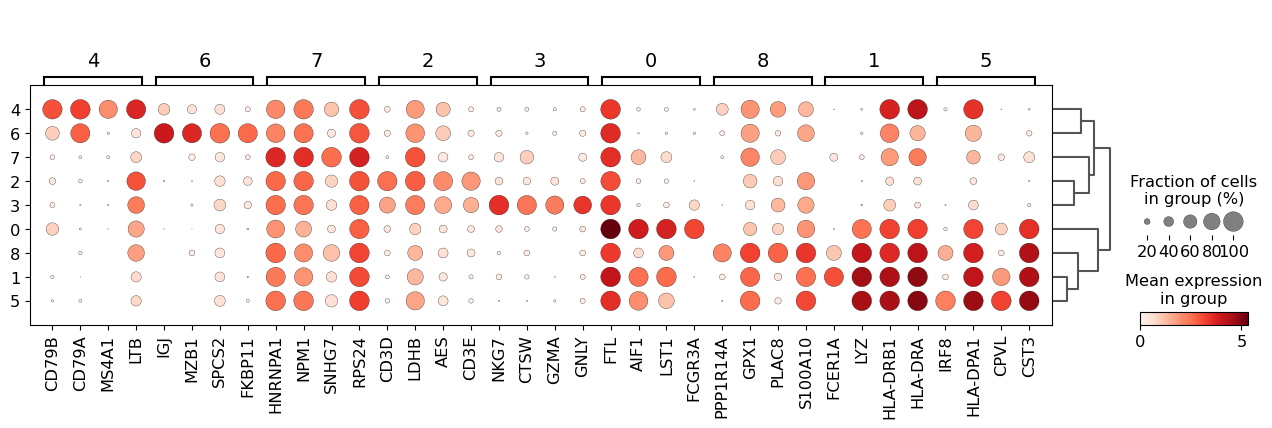

In [28]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

In order to get a better representation we can plot log fold changes instead of gene expression. Also, we want to focus on genes that have a log fold change >= 3 between the cell type expression and the rest of cells.

In this case we set values_to_plot='logfoldchanges' and min_logfoldchange=3.

Because log fold change is a divergent scale we also adjust the min and max to be plotted and use a divergent color map. Notice in the following plot that is rather difficult to distinguish between T-cell populations.

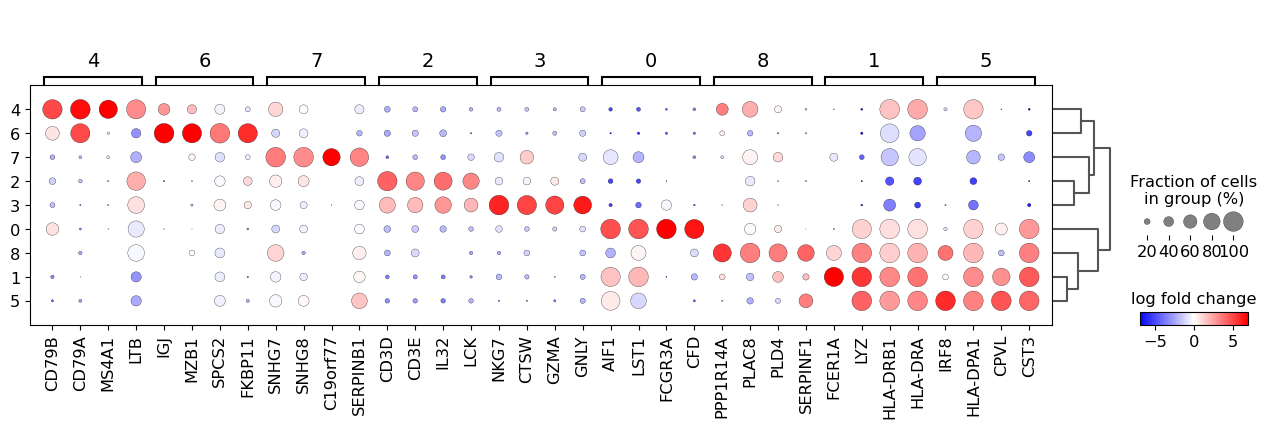

In [29]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4, values_to_plot='logfoldchanges', 
                                min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

**Focusing on particular groups**

Next, we use a dotplot focusing only on two groups (the groups option is also available for violin, heatmap and matrix plots). Here, we set n_genes=30 as in this case it will show all the genes that have a min_logfoldchange=4 up to 30.

categories: 0, 1, 2, etc.
var_group_labels: 1, 5


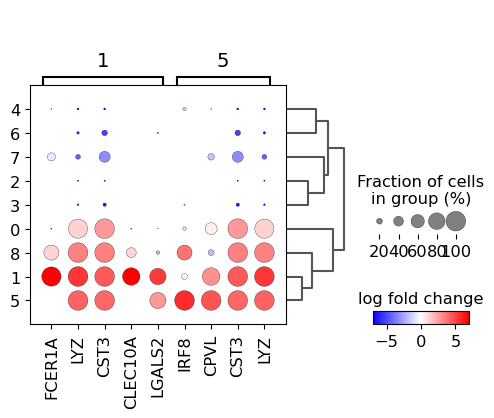

In [30]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=30, values_to_plot='logfoldchanges', 
                                min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['1', '5'])

**Visualize marker genes using matrix plot**

For the following plot we use the previously computed ‘scaled’ values (stored in layer scaled) and use a divergent color map.

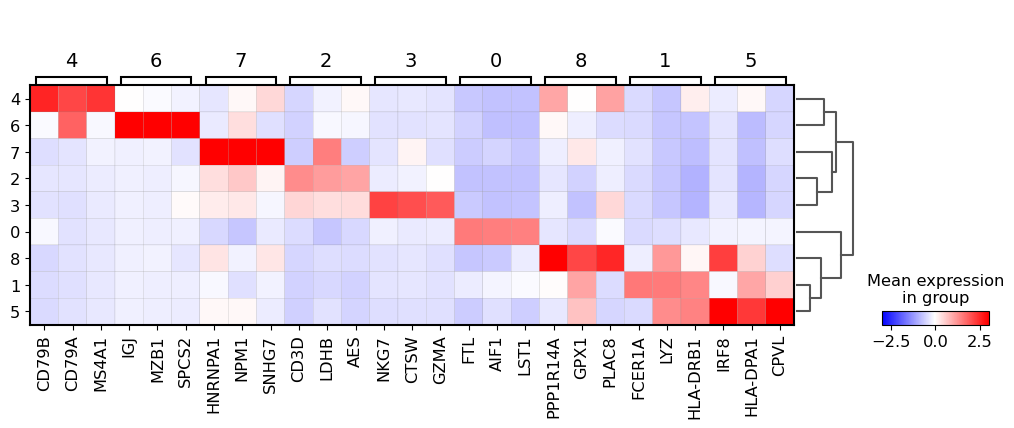

In [31]:
sc.pl.rank_genes_groups_matrixplot(pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

**Visualize marker genes using stacked violin plot**

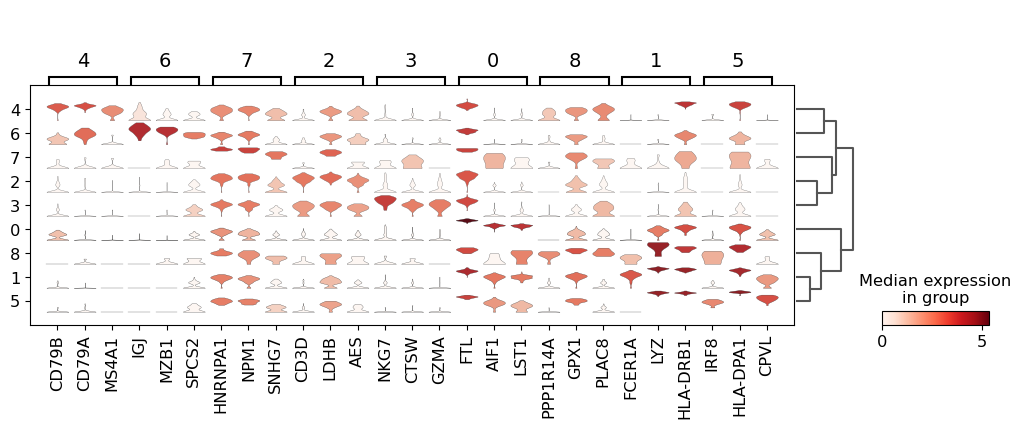

In [32]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap='Reds')

**Visualize marker genes using heatmap**

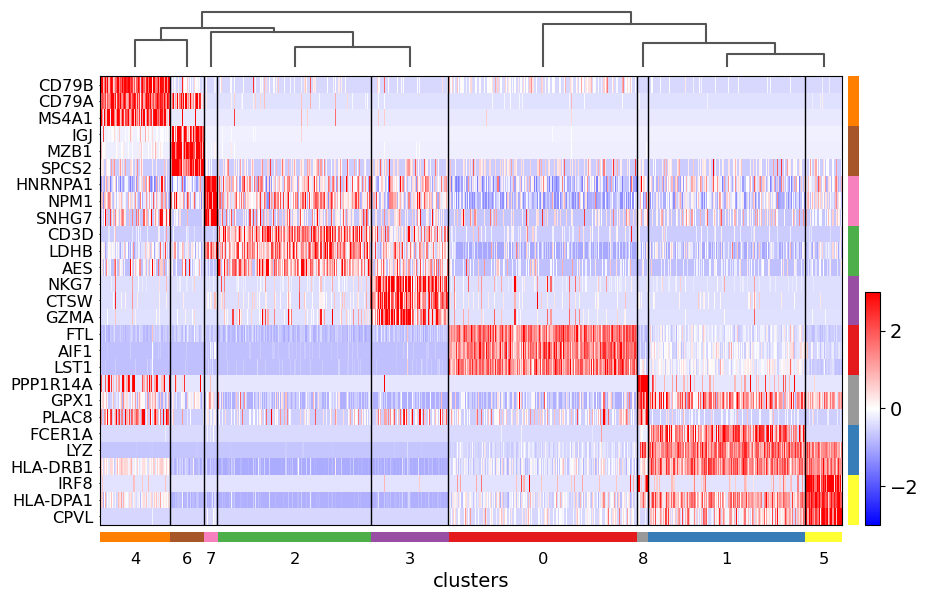

In [33]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, 
                                vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);

Showing 10 genes per category, turning the gene labels off and swapping the axes. Notice that when the image is swapped, a color code for the categories appear instead of the ‘brackets’.

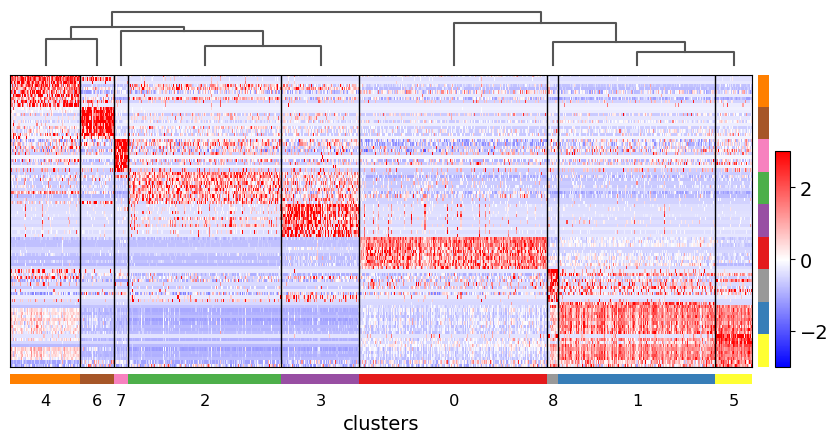

In [34]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

**Visualize marker genes using tracksplot**

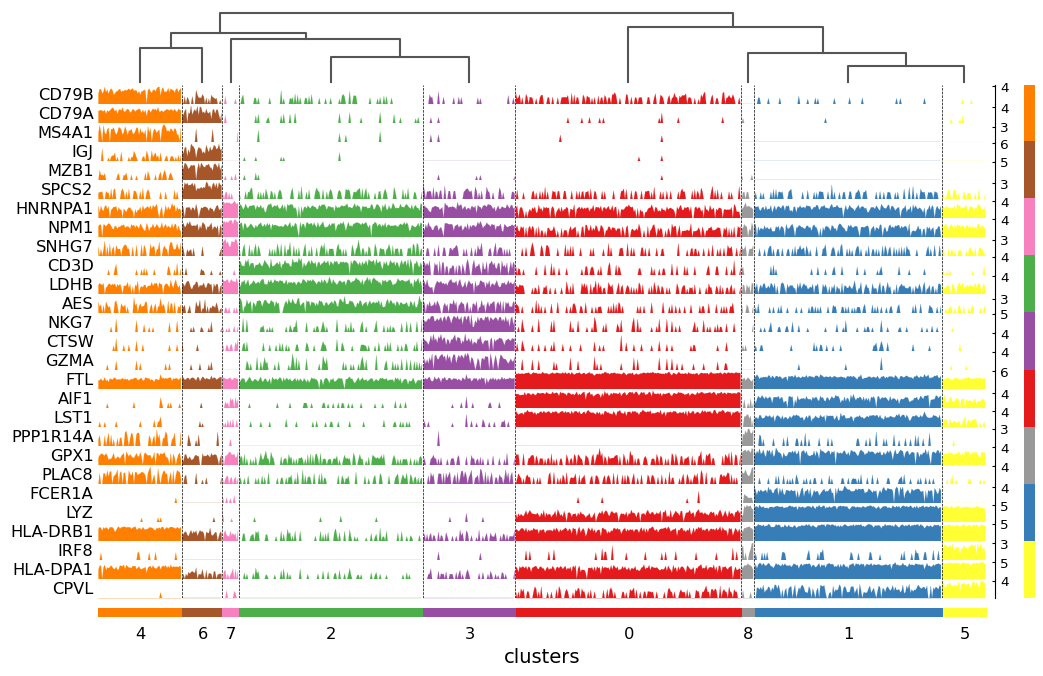

In [35]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

##**Comparison of marker genes using split violin plots**

In scanpy, is very easy to compare marker genes using split violin plots for all groups at once.

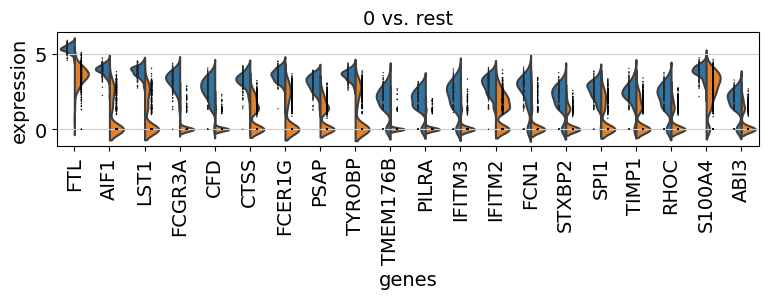

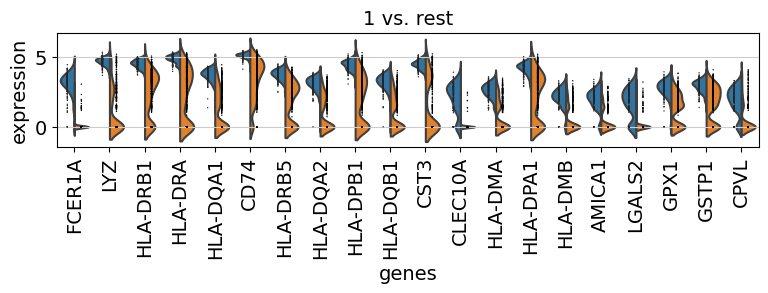

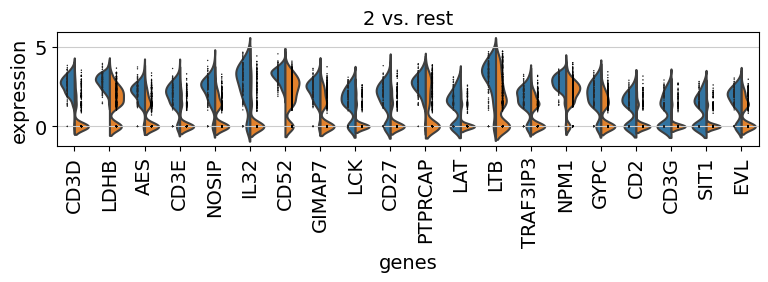

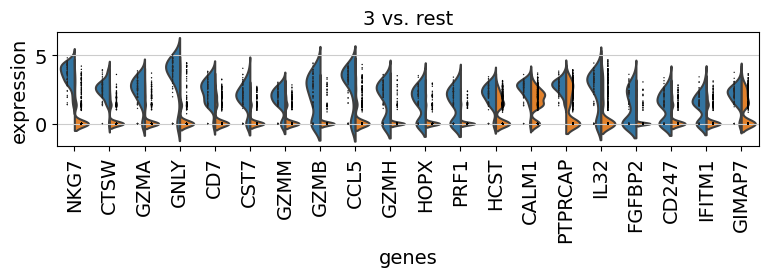

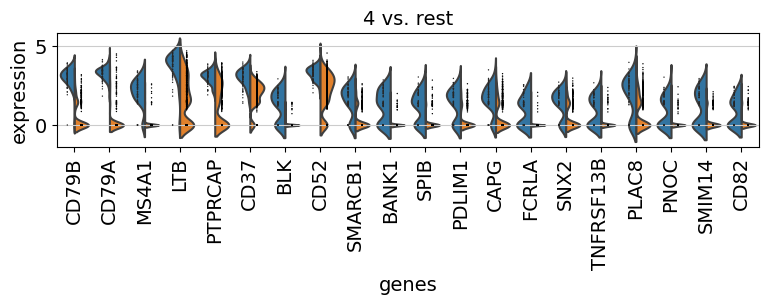

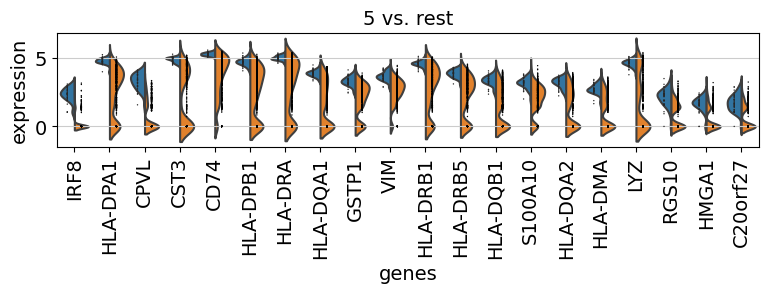

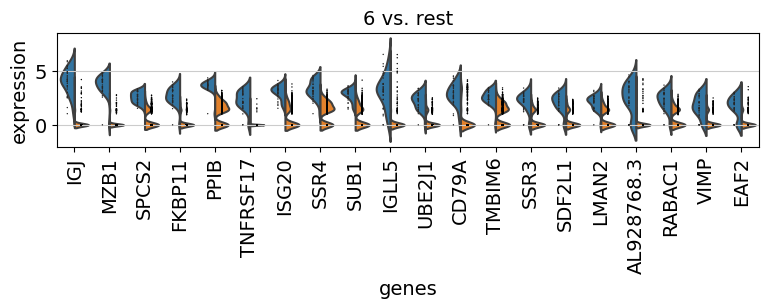

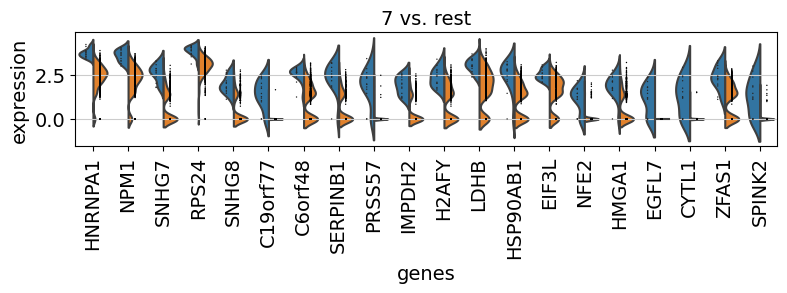

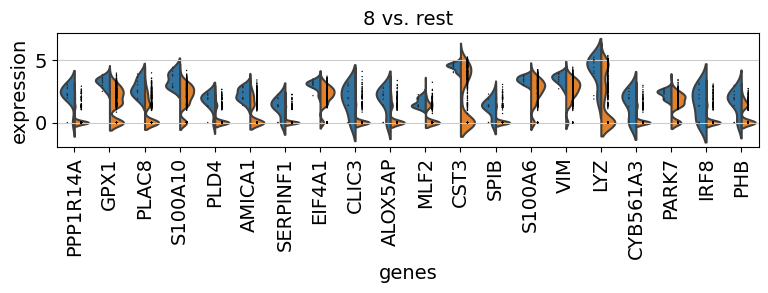

In [36]:
with rc_context({"figure.figsize": (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)

##**Dendrogram options**

Most of the visualizations can arrange the categories using a dendrogram. However, the dendrogram can also be plotted independently as follows:



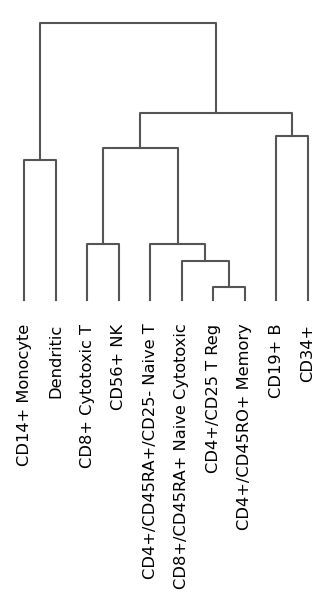

In [39]:
# compute hierarchical using PCs (several distance metrics and linkage methods are available)
sc.pl.dendrogram(pbmc, "bulk_labels")

##**Plot correlation**

Together with the dendrogram it is possible to plot the correlation (by default ‘pearson’) of the categories.

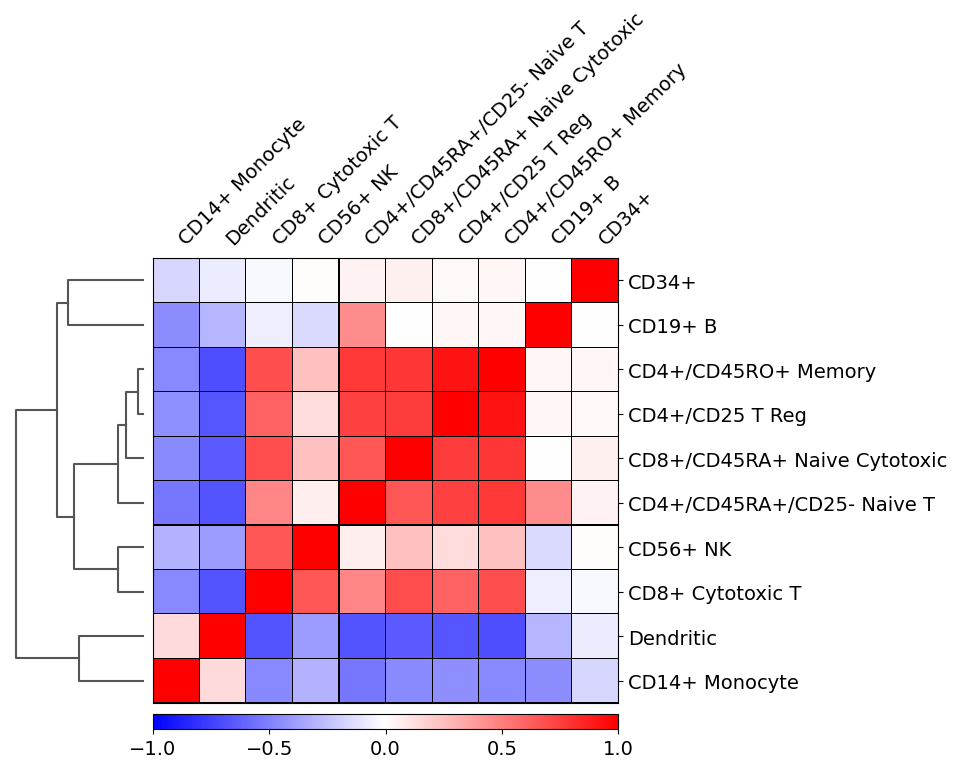

In [43]:
sc.pl.correlation_matrix(pbmc, "bulk_labels")